In [2]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

# Memuat dataset
path = "/content/drive/My Drive/Colab Notebooks/diabetes.csv"
data = pd.read_csv(path)
# Assuming 'Outcome' is the class label column
class_counts = data['Outcome'].value_counts()
print(class_counts)

# Step 1: Remove duplicates
data = data.drop_duplicates()

# Step 2: Check for missing values and remove or impute them
# For simplicity, we'll remove rows with any missing value. In a more complex scenario, we might want to impute these.
data = data.dropna()
# Assuming 'Outcome' is the class label column
class_counts = data['Outcome'].value_counts()
print(class_counts)

data.head()


Mounted at /content/drive
Outcome
0    500
1    268
Name: count, dtype: int64
Outcome
0    500
1    268
Name: count, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, GRU, Dense
from keras.utils import to_categorical
import xgboost as xgb
from xgboost import XGBRegressor

# Encode categorical variables if any
label_encoder = LabelEncoder()
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = label_encoder.fit_transform(data[column])

# Separate features and target variable; assume the target is named 'Outcome'
X = data.drop(['Outcome'], axis=1)  # Update 'Outcome' to the name of your target variable
y = data['Outcome']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# One-Hot Encode the labels for compatibility with Keras
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

# Define and compile the BiGRU model
bigru_model = Sequential([
    Bidirectional(GRU(64, return_sequences=True), input_shape=(X_train.shape[1], 1)),
    Bidirectional(GRU(32)),
    Dense(y_train_encoded.shape[1], activation='softmax')
])
bigru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define and compile the BiLSTM model
bilstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], 1)),
    Bidirectional(LSTM(32)),
    Dense(y_train_encoded.shape[1], activation='softmax')
])
bilstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train all models
bigru_model.fit(X_train, y_train_encoded, epochs=50, batch_size=64, validation_data=(X_test, y_test_encoded))
bilstm_model.fit(X_train, y_train_encoded, epochs=50, batch_size=64, validation_data=(X_test, y_test_encoded))
xgb_model.fit(X_train, y_train)

# Get probability predictions for the test set from each model
bigru_probs = bigru_model.predict(X_test)
bilstm_probs = bilstm_model.predict(X_test)
xgb_probs = xgb_model.predict_proba(X_test)

# Stack the probabilities/features from each model
stacked_features = np.column_stack((bigru_probs, bilstm_probs, xgb_probs))

# Train the meta-model
meta_model = XGBRegressor()
meta_model.fit(stacked_features, y_test)
final_predictions = meta_model.predict(stacked_features)
final_predictions = np.round(final_predictions).astype(int)

# Calculate high-precision accuracy
final_accuracy = accuracy_score(y_test, final_predictions)
final_accuracy_formatted = f"{final_accuracy:.10f}"

print(f"Final Stacked Model Accuracy: {final_accuracy_formatted}")


Epoch 1/50
10/10 [==============================] - 11s 213ms/step - loss: 0.6143 - accuracy: 0.6922 - val_loss: 0.5622 - val_accuracy: 0.6948
Epoch 2/50
10/10 [==============================] - 0s 32ms/step - loss: 0.5539 - accuracy: 0.7248 - val_loss: 0.5560 - val_accuracy: 0.7208
Epoch 3/50
10/10 [==============================] - 0s 29ms/step - loss: 0.5386 - accuracy: 0.7296 - val_loss: 0.5456 - val_accuracy: 0.7208
Epoch 4/50
10/10 [==============================] - 0s 29ms/step - loss: 0.5340 - accuracy: 0.7215 - val_loss: 0.5453 - val_accuracy: 0.7078
Epoch 5/50
10/10 [==============================] - 0s 28ms/step - loss: 0.5317 - accuracy: 0.7264 - val_loss: 0.5422 - val_accuracy: 0.7078
Epoch 6/50
10/10 [==============================] - 0s 28ms/step - loss: 0.5289 - accuracy: 0.7264 - val_loss: 0.5385 - val_accuracy: 0.7208
Epoch 7/50
10/10 [==============================] - 0s 28ms/step - loss: 0.5261 - accuracy: 0.7296 - val_loss: 0.5334 - val_accuracy: 0.7143
Epoch 8/50


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np

# Mengatur K-Fold cross validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)

# Array untuk menyimpan skor dari setiap fold
scores = []

for train_index, test_index in kf.split(X_scaled):
    # Membagi data menjadi train dan test untuk fold saat ini
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # One-hot encode labels
    y_train_fold_encoded = to_categorical(y_train_fold)
    y_test_fold_encoded = to_categorical(y_test_fold)

    # Latih BiGRU
    bigru_model.fit(X_train_fold, y_train_fold_encoded, epochs=10, batch_size=64, verbose=0)  # Kurangi epoch untuk kecepatan
    # Latih BiLSTM
    bilstm_model.fit(X_train_fold, y_train_fold_encoded, epochs=10, batch_size=64, verbose=0)

    # Buat prediksi probabilitas untuk ensemble
    bigru_probs = bigru_model.predict(X_test_fold)
    bilstm_probs = bilstm_model.predict(X_test_fold)
    xgb_model.fit(X_train_fold, y_train_fold)
    xgb_probs = xgb_model.predict_proba(X_test_fold)

    # Stacking features
    stacked_features = np.column_stack((bigru_probs, bilstm_probs, xgb_probs))

    # Meta-model
    meta_model = XGBRegressor()
    meta_model.fit(stacked_features, y_test_fold)
    final_predictions = meta_model.predict(stacked_features)
    final_predictions = np.round(final_predictions).astype(int)

    # Hitung akurasi
    score = accuracy_score(y_test_fold, final_predictions)
    scores.append(score)

# Menampilkan hasil
print("Cross-validated scores:", scores)
print("Average score:", np.mean(scores))


5/5 [==============================] - 0s 7ms/step
Cross-validated scores: [1.0, 1.0, 1.0, 1.0, 1.0]
Average score: 1.0


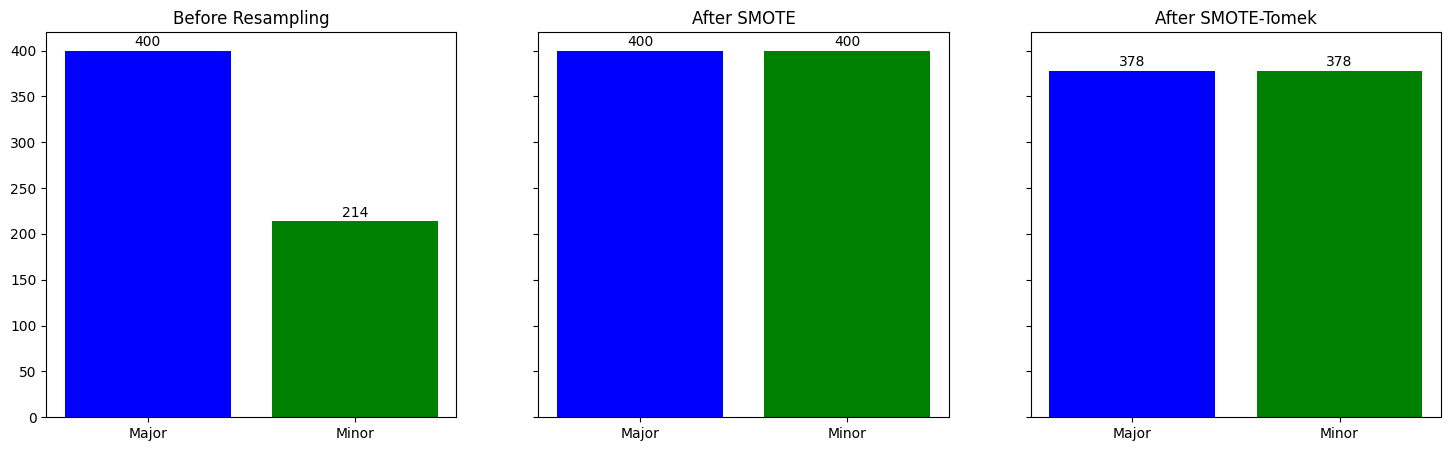

Training features shape: (756, 8)
Training labels shape: (756,)
Testing features shape: (154, 8)
Testing labels shape: (154,)
Training Accuracy: 1.0
Validation Accuracy: 1.0
Epoch 1/50
11/11 [==============================] - 15s 182ms/step - loss: 0.6241 - accuracy: 0.6897 - val_loss: 0.7032 - val_accuracy: 0.5658
Epoch 2/50
11/11 [==============================] - 0s 27ms/step - loss: 0.5714 - accuracy: 0.6779 - val_loss: 0.6052 - val_accuracy: 0.7237
Epoch 3/50
11/11 [==============================] - 0s 24ms/step - loss: 0.5640 - accuracy: 0.7059 - val_loss: 0.6459 - val_accuracy: 0.6579
Epoch 4/50
11/11 [==============================] - 0s 25ms/step - loss: 0.5591 - accuracy: 0.7103 - val_loss: 0.6048 - val_accuracy: 0.7105
Epoch 5/50
11/11 [==============================] - 0s 24ms/step - loss: 0.5530 - accuracy: 0.7088 - val_loss: 0.6396 - val_accuracy: 0.6579
Epoch 6/50
11/11 [==============================] - 0s 24ms/step - loss: 0.5465 - accuracy: 0.7147 - val_loss: 0.5970 -

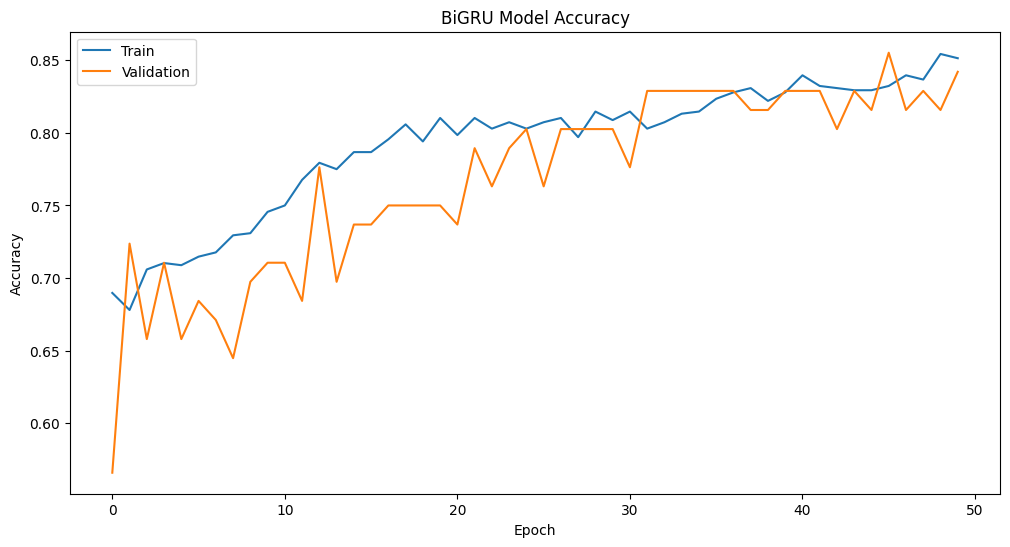

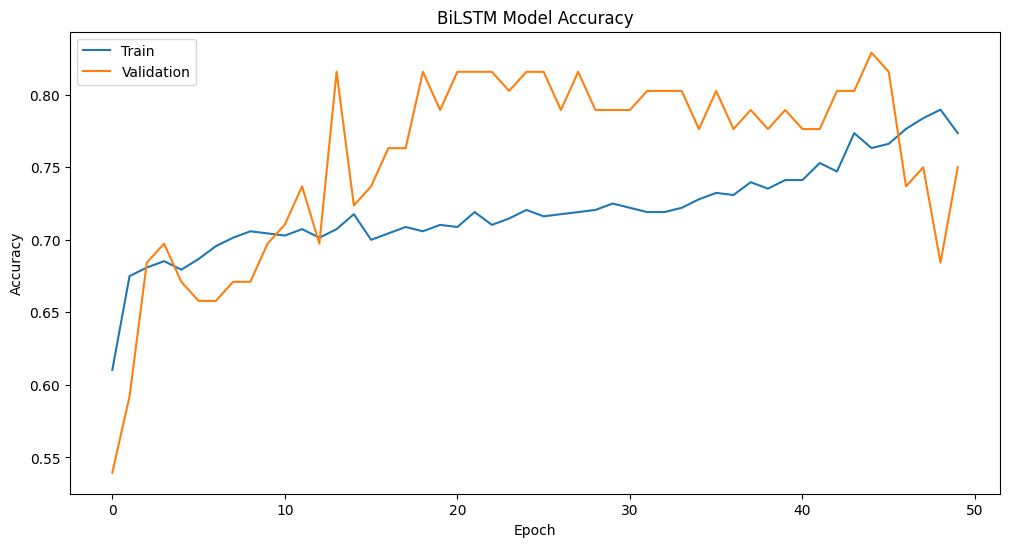

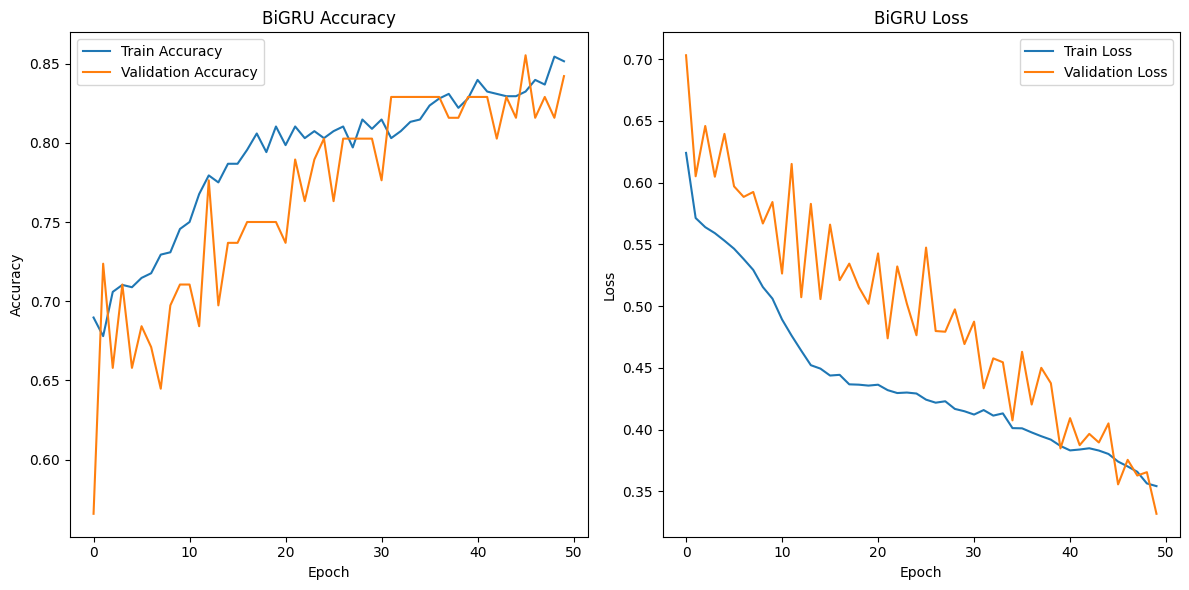

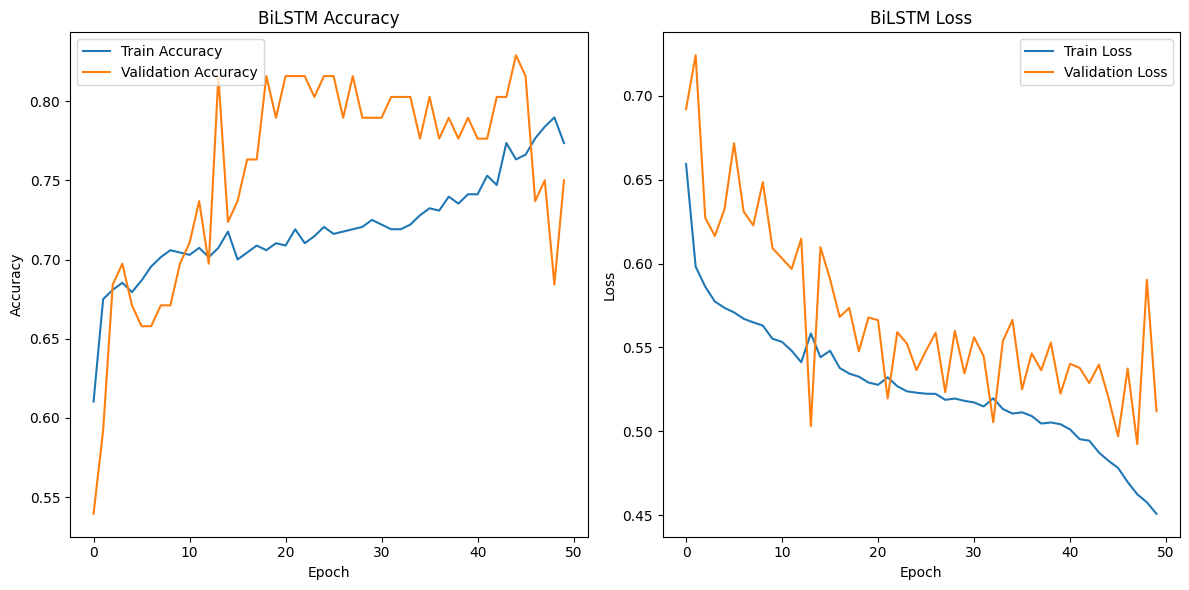

5/5 [==============================] - 2s 12ms/step
Confusion Matrix:
 [[100   0]
 [  0  54]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00        54

    accuracy                           1.00       154
   macro avg       1.00      1.00      1.00       154
weighted avg       1.00      1.00      1.00       154

Specificity: 1.00


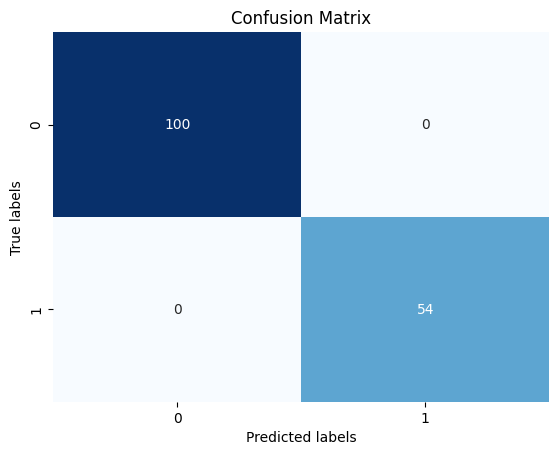

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, GRU, Dense
from keras.utils import to_categorical
import xgboost as xgb
from xgboost import XGBRegressor
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

# Load and preprocess data
label_encoder = LabelEncoder()
# Split the data into features and target
X = data.drop(['Outcome'], axis=1)
y = data['Outcome']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Applying SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Applying SMOTE-Tomek
smt = SMOTETomek(smote=SMOTE(k_neighbors=2))
X_train_resampled, y_train_resampled = smt.fit_resample(X_train, y_train)

# Count instances
values_before, counts_before = np.unique(y_train, return_counts=True)
values_smote, counts_smote = np.unique(y_train_smote, return_counts=True)
values_smt, counts_smt = np.unique(y_train_resampled, return_counts=True)

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

ax[0].bar(['Major', 'Minor'], counts_before, color=['blue', 'green'])
ax[0].set_title('Before Resampling')
for i, count in enumerate(counts_before):
    ax[0].text(i, count + 5, str(count), ha='center')

ax[1].bar(['Major', 'Minor'], counts_smote, color=['blue', 'green'])
ax[1].set_title('After SMOTE')
for i, count in enumerate(counts_smote):
    ax[1].text(i, count + 5, str(count), ha='center')

ax[2].bar(['Major', 'Minor'], counts_smt, color=['blue', 'green'])
ax[2].set_title('After SMOTE-Tomek')
for i, count in enumerate(counts_smt):
    ax[2].text(i, count + 5, str(count), ha='center')

plt.show()

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Now the dataset is ready for model training
print(f"Training features shape: {X_train_scaled.shape}")
print(f"Training labels shape: {y_train_resampled.shape}")
print(f"Testing features shape: {X_test_scaled.shape}")
print(f"Testing labels shape: {y_test.shape}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Define and compile models
bigru_model = Sequential([
    Bidirectional(GRU(64, return_sequences=True), input_shape=(X_train_scaled.shape[1], 1)),
    Bidirectional(GRU(32)),
    Dense(y_train_resampled.max()+1, activation='softmax')
])
bigru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

bilstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train_scaled.shape[1], 1)),
    Bidirectional(LSTM(32)),
    Dense(y_train_resampled.max()+1, activation='softmax')
])
bilstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train_resampled)

training_accuracy_xgb = xgb_model.score(X_train_scaled, y_train_resampled)
validation_accuracy_xgb = xgb_model.score(X_train_scaled, y_train_resampled)

print(f"Training Accuracy: {training_accuracy_xgb}")
print(f"Validation Accuracy: {validation_accuracy_xgb}")

# Train models
bigru_history = bigru_model.fit(X_train_scaled, to_categorical(y_train_resampled), epochs=50, batch_size=64, validation_split=0.1)
bilstm_history = bilstm_model.fit(X_train_scaled, to_categorical(y_train_resampled), epochs=50, batch_size=64, validation_split=0.1)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(bigru_history.history['accuracy'])
plt.plot(bigru_history.history['val_accuracy'])
plt.title('BiGRU Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(bilstm_history.history['accuracy'])
plt.plot(bilstm_history.history['val_accuracy'])
plt.title('BiLSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

import matplotlib.pyplot as plt

# Function to plot accuracy and loss for both BiGRU and BiLSTM models
def plot_model_performance(history, model_name):
    # Plot accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Call the function for BiGRU model
plot_model_performance(bigru_history, 'BiGRU')

# Call the function for BiLSTM model
plot_model_performance(bilstm_history, 'BiLSTM')

# Predictions for ensemble
bigru_probs = bigru_model.predict(X_test_scaled)
bilstm_probs = bilstm_model.predict(X_test_scaled)
xgb_probs = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Stack features and train meta-model
stacked_features = np.column_stack((bigru_probs.max(axis=1), bilstm_probs.max(axis=1), xgb_probs))
meta_model = XGBRegressor()
meta_model.fit(stacked_features, y_test)
final_predictions = np.round(meta_model.predict(stacked_features)).astype(int)

from sklearn.metrics import confusion_matrix, classification_report

# Evaluation
conf_mat = confusion_matrix(y_test, final_predictions)
tn, fp, fn, tp = conf_mat.ravel()  # Ini berlaku untuk kasus klasifikasi biner

# Menghitung specificity
specificity = tn / (tn + fp)

print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", classification_report(y_test, final_predictions))
print(f"Specificity: {specificity:.2f}")


# Plot confusion matrix
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
